In [75]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Select file

In [76]:
def file_content(path):
    with open(path, "r") as file:
        content = file.read()
        json_content = json.loads(content)  
        file.close()
        return json_content

# Select a results file

def select_file(folder_path, idx):
    results_files = os.listdir(folder_path)
    for i, file in enumerate(results_files):
        print(f"{i}: {file}")
    if idx < 0 or idx >= len(results_files):
        print("Invalid index. Please select a valid file index.")
        return None
    selcted_file = results_files[idx]
    print("Selected file: ", selcted_file)
    
    report = file_content(os.path.join(folder_path, selcted_file))
    
    return report

# In case of hyperparameter tuning, the report file is named differently
def report_file_name(run_id, fold_i):
    return f"report_{run_id}_fold_{fold_i}.json"


def open_single_report_file(file_path):
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist")
        return None
    
    report = file_content(file_path)
    return report

def open_5fcv_report(results_folder, run_id, fold_i):
    file_name = report_file_name(run_id, fold_i)
    file_path = os.path.join(results_folder, file_name)
    return open_single_report_file(file_path)


# Report metrics extraction

In [77]:
class Report:
    def __init__(self, report: dict):
        self.report = report
        self.clean()
    
    def clean(self):
        try:
            rounds = self.report["central_eval"]
            if not bool(rounds[0]): # skip empty rounds
                self.report["central_eval"] = rounds[1:]
        except:
            pass

    
    def hyperparams(self):
        return self.report["hyperparams"]

    def extract_central_eval_metric(self, metric) -> tuple[np.ndarray, np.ndarray]:
        rounds = self.report["central_eval"]

        metric_data = np.array([rounds[i][metric] for i in range(len(rounds))])
        return metric_data


    
    def extract_fit_config_metric(self, metric) -> tuple[np.ndarray, np.ndarray]:
        rounds = self.report["fit_config"]
        print(rounds)
        rounds_data = np.array([rounds[i]["round"] for i in range(len(rounds))])
        metric_data = np.array([rounds[i][metric] for i in range(len(rounds))])
        return rounds_data, metric_data

        
class FiveFoldResults():
    def __init__(self, reports: list[Report]):
        self.reports = reports
        self.validate_reports()
        
    def validate_reports(self):
        if len(self.reports) != 5:
            raise ValueError("There should be exactly 5 reports for 5-fold cross-validation.")
        
        for i in range(1, len(self.reports)):
            if self.reports[i].report["hyperparams"] != self.reports[0].report["hyperparams"]:
                raise ValueError("Hyperparameters do not match across reports.")   
            
            if self.reports[i].report["run_id"] != self.reports[0].report["run_id"]:
                raise ValueError("Run IDs do not match across reports.")
            
            
    def get_experiment_name(self):
        return self.reports[0].report["experiment_name"]
    
    def get_start_time(self):
        return self.reports[0].report["start_time"]
        
    def hyperparameters(self):
        return self.reports[0].report["hyperparams"]
        
    def get_mean_std(self, metric: str) -> tuple[np.ndarray, np.ndarray]:
        all_metrics = []
        x = None
        
        for report in self.reports:
            x, metric_values = report.extract_central_eval_metric(metric)
            all_metrics.append(metric_values)
            
        all_metrics = np.array(all_metrics)
        
        mean = np.mean(all_metrics, axis=0)
        std = np.std(all_metrics, axis=0)
        
        return x, mean, std
    
    def get_max_final(self, metric: str):
        return self.get_max(metric), self.get_final(metric)
    
    def get_max(self, metric: str):
        _, mean, _ = self.get_mean_std(metric)

        return np.round(np.max(mean), 3)
    
    def get_final(self, metric: str):
        _, mean, _ = self.get_mean_std(metric)
        
        return np.round(mean[-1], 3)

# Single report resuls

In [78]:
# Reports location and information
report_path = "./experiment3_domain_results/report_0_fold_0.json"


report_content = open_single_report_file(file_path=report_path)

if report_content is None:
    print("No report found")
    exit(1)

report = Report(report_content)
report.clean()

# Multi report results

In [79]:
class MultiReport:
    def __init__(self, reports_folder: str, report_num: int):
        self.reports = []
        for i in range(5):
            report = Report(open_single_report_file(file_path=f"{reports_folder}report_{str(report_num)}_fold_{str(i)}.json"))
            self.reports.append(report)

    def get_mean_var_metric(self, metric: str):
        metrics = []
        for report in self.reports:
            try:
                metric_list = report.extract_central_eval_metric(metric)
                if len(metric_list) < 50:
                    continue
                metrics.append(metric_list)
            except:
                print(f"Metric {metric} not found in report {self.hyperparams()}")
                pass
        
        metrics = np.array(metrics)

        return np.mean(metrics, axis=0), np.std(metrics, axis=0)
    
    def hyperparams(self):
        return self.reports[0].hyperparams()

In [80]:
axis_font_size = 14
title_font_size = 16
fig_title_font_size = 18
legend_font_size = 14

In [81]:
class Plot:
    def __init__(self, shape=(1,1)):
        fig, ax = plt.subplots(shape[0], shape[1])
        self.fig = fig
        self.ax = ax
        self.fig.set_size_inches(12, 6)
        # Make space in the vertical axis
        fig.subplots_adjust(hspace=0.5, wspace=0.3)

    def plot_mean_std(self, index, mean_data: np.ndarray, std_data: np.ndarray, title: str = "", name: str = "", x_label: str = "Rounds", y_label: str = "Metric") -> tuple[plt.Figure, plt.Axes]:
        rounds = np.arange(len(mean_data))

        self.ax[index].plot(rounds, mean_data, label=f"{title} (Mean)")

        self.ax[index].fill_between(
            rounds,
            mean_data - std_data,
            mean_data + std_data,
            alpha=0.1,
            # label=f"{name} (Standard Deviation)",
        )

        self.ax[index].set_xlabel(x_label, fontsize=axis_font_size)
        self.ax[index].set_ylabel(y_label, fontsize=axis_font_size)
        self.ax[index].set_title(title, fontsize=title_font_size)

        self.ax[index].set_ylim(0, 1)

        self.ax[index].grid()
        # self.ax[index].legend()
        # Show last value of mean_data on the plot
        # self.ax[index].text(
        #     rounds[-1] + 5,
        #     mean_data[-1],
        #     f"{mean_data[-1]:.3f}",
        #     fontsize=10,
        #     verticalalignment="bottom",
        #     horizontalalignment="right",
        #     color="black",
        #     bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
        # )
        

        return self.fig, self.ax

    def plot_all_metrics(self, index, metric: str, multireport: MultiReport, title: str = "", add_labels: bool = False):
        def plot_mean_std_helper(mean_data: np.ndarray, std_data: np.ndarray, name: str = ""):
            rounds = np.arange(len(mean_data))

            self.ax[index].plot(rounds, mean_data, label=f"{name}") if add_labels else self.ax[index].plot(rounds, mean_data)

            self.ax[index].fill_between(
                rounds,
                mean_data - std_data,
                mean_data + std_data,
                alpha=0.1,
                # label=f"{name} (Standard Deviation)",
            )

        self.ax[index].set_ylim(0, 1)
        for i in ["01", "23", "45", "67", "89"]:
            mean, std = multireport.get_mean_var_metric(f"{metric}_{i}")
            plot_mean_std_helper(mean, std, name=f"Domain {i}")
        self.ax[index].set_title(f"Accuracy on Client Domains", fontsize=title_font_size)
        self.ax[index].set_xlabel("Rounds", fontsize=axis_font_size)
        self.ax[index].set_ylabel("Accuracy", fontsize=axis_font_size)
        self.ax[index].set_title(title, fontsize=title_font_size)
        self.ax[index].grid()

        return self.fig, self.ax

Metric accuracy_global not found in report {'ILVariant': 'Domain', 'ILStrategy': 'StandardFL'}


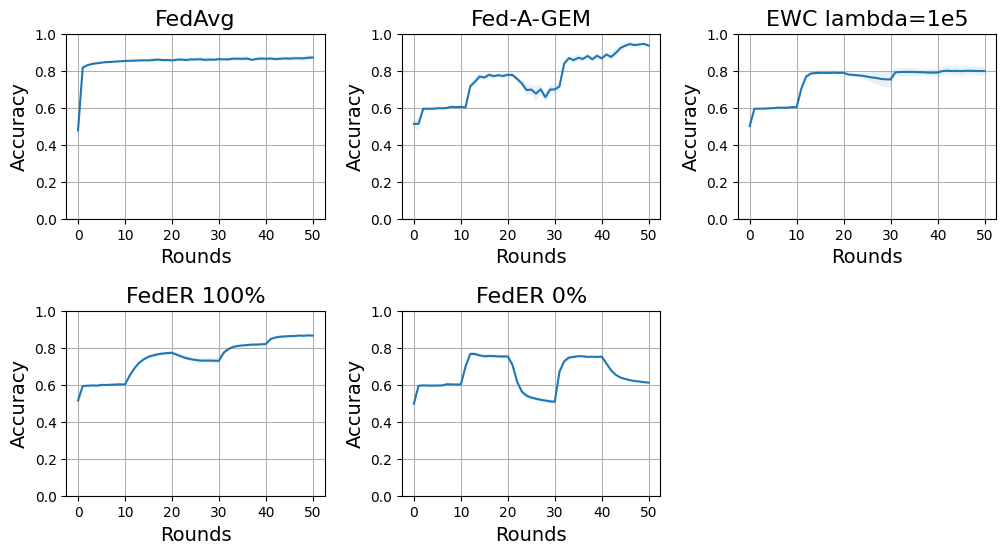

In [82]:
mr0 = MultiReport("./experiment3_domain_results/", 0)
mr1 = MultiReport("./experiment3_domain_results/", 1)
mr2 = MultiReport("./experiment3_domain_results/", 2)
mr3 = MultiReport("./experiment3_domain_results/", 3)
mr4 = MultiReport("./experiment3_EWC_results/", 0)

mean0, std0 = mr0.get_mean_var_metric("accuracy_global")
mean1, std1 = mr1.get_mean_var_metric("accuracy_global")
mean2, std2 = mr2.get_mean_var_metric("accuracy_global")
mean3, std3 = mr3.get_mean_var_metric("accuracy_global")
mean4, std4 = mr4.get_mean_var_metric("accuracy_global")

p = Plot(shape=(2, 3))

p.plot_mean_std((0,0), mean0, std0, title="FedAvg", name="Global Accuracy", y_label="Accuracy")
p.plot_mean_std((0,1), mean1, std1, title="Fed-A-GEM", name="Global Accuracy", y_label="Accuracy")
p.plot_mean_std((1,0), mean2, std2, title="FedER 100%", name="Global Accuracy", y_label="Accuracy")
p.plot_mean_std((1,1), mean3, std3, title="FedER 0%", name="Global Accuracy", y_label="Accuracy")
fig, ax = p.plot_mean_std((0,2), mean4, std4, title="EWC lambda=1e5", name="Global Accuracy", y_label="Accuracy")
ax[1,2].set_visible(False)  # Hide the empty subplot

# fig.suptitle("Global accuracy of every tested FL algorithm (FDIL)", fontsize=fig_title_font_size)

fig.savefig("exp3_FL_global_accuracy_domain.svg", format="svg", bbox_inches='tight')

In [83]:
mr = MultiReport("./experiment3_task_results/", 3)
mr = MultiReport("./experiment3_EWC_results/", 1)

mean_global, std_global = mr.get_mean_var_metric("accuracy_global")
mean_01, std_01 = mr.get_mean_var_metric("accuracy_01")
mean_23, std_23 = mr.get_mean_var_metric("accuracy_23")
mean_45, std_45 = mr.get_mean_var_metric("accuracy_45")
mean_67, std_67 = mr.get_mean_var_metric("accuracy_67")
mean_89, std_89 = mr.get_mean_var_metric("accuracy_89")

def print_final_mean_std(mean, std, label, bold=False):
    """Print the final mean and std of the accuracies."""
    if bold:
        print("\\acctstdbold{" + f"{mean:.3f}" +"}{" + f"{std:.3f}" +"}")
    else:
        print("\\acctstd{" + f"{mean:.3f}" +"}{" + f"{std:.3f}" +"}")

print_final_mean_std(mean_global[-1], std_global[-1], "Global", bold=True)
print_final_mean_std(mean_01[-1], std_01[-1], "0's and 1's")
print_final_mean_std(mean_23[-1], std_23[-1], "2's and 3's")
print_final_mean_std(mean_45[-1], std_45[-1], "4's and 5's")
print_final_mean_std(mean_67[-1], std_67[-1], "6's and 7's")
print_final_mean_std(mean_89[-1], std_89[-1], "8's and 9's")

mr.hyperparams()

\acctstdbold{0.895}{0.022}
\acctstd{0.911}{0.095}
\acctstd{0.923}{0.033}
\acctstd{0.900}{0.054}
\acctstd{0.788}{0.126}
\acctstd{0.955}{0.012}


{'ILVariant': 'Task', 'ILStrategy': 'EWC'}

Metric accuracy_01 not found in report {'ILVariant': 'Domain', 'ILStrategy': 'StandardFL'}
Metric accuracy_23 not found in report {'ILVariant': 'Domain', 'ILStrategy': 'StandardFL'}
Metric accuracy_45 not found in report {'ILVariant': 'Domain', 'ILStrategy': 'StandardFL'}
Metric accuracy_67 not found in report {'ILVariant': 'Domain', 'ILStrategy': 'StandardFL'}
Metric accuracy_89 not found in report {'ILVariant': 'Domain', 'ILStrategy': 'StandardFL'}


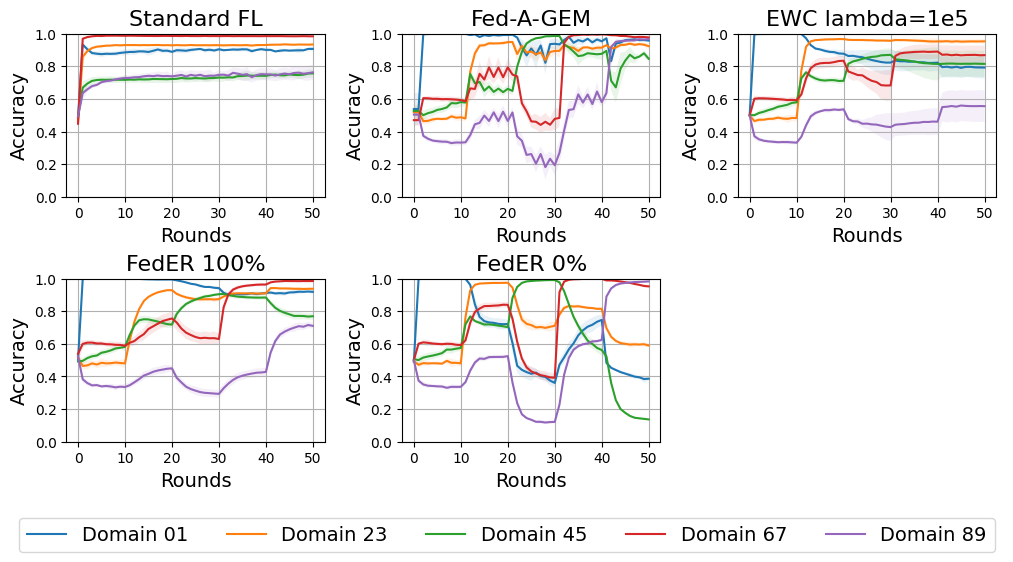

In [84]:
mr0 = MultiReport("./experiment3_domain_results/", 0)
mr1 = MultiReport("./experiment3_domain_results/", 1)
mr2 = MultiReport("./experiment3_domain_results/", 2)
mr3 = MultiReport("./experiment3_domain_results/", 3)
mr4 = MultiReport("./experiment3_EWC_results/", 0)


p = Plot(shape=(2, 3))

p.plot_all_metrics((0, 0), "accuracy", mr0, title="Standard FL", add_labels=True)
p.plot_all_metrics((0, 1), "accuracy", mr1, title="Fed-A-GEM")
p.plot_all_metrics((1, 0), "accuracy", mr2, title="FedER 100%")
p.plot_all_metrics((1, 1), "accuracy", mr3, title="FedER 0%")
fig, ax = p.plot_all_metrics((0, 2), "accuracy", mr4, title="EWC lambda=1e5")
ax[1,2].set_visible(False)  # Hide the empty subplot

# fig.suptitle("Client accuracies of every tested FL algorithm (FDIL)", fontsize=fig_title_font_size)
fig.legend(loc='lower center', ncol=5, fontsize=legend_font_size)
fig.subplots_adjust(bottom=0.2)

fig.savefig("exp3_FL_domain_accuracy_domain.svg", format="svg", bbox_inches='tight')

Ved hurtigt kig igennem de kilder vi har brugt, så er det her novel for normal MNIST dataset.

Dog stemmer resultaterne, om at Fed-A-GEM forbedrer resultaterne, overens med dem i artiklen: https://arxiv.org/pdf/2409.01585

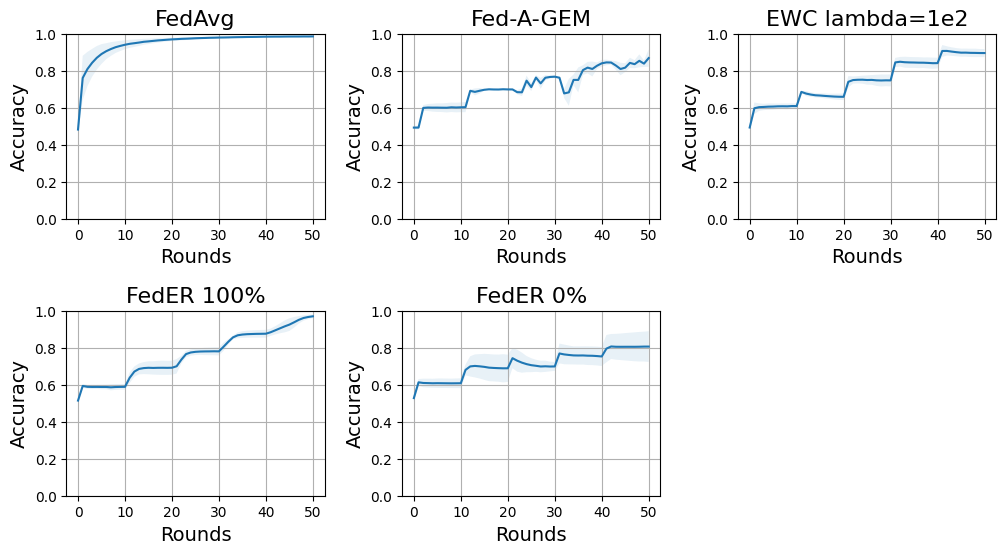

In [85]:
mr0 = MultiReport("./experiment3_task_results/", 0)
mr1 = MultiReport("./experiment3_task_results/", 1)
mr2 = MultiReport("./experiment3_task_results/", 2)
mr3 = MultiReport("./experiment3_task_results/", 3)
mr4 = MultiReport("./experiment3_EWC_results/", 1)


mean0, std0 = mr0.get_mean_var_metric("accuracy_global")
mean1, std1 = mr1.get_mean_var_metric("accuracy_global")
mean2, std2 = mr2.get_mean_var_metric("accuracy_global")
mean3, std3 = mr3.get_mean_var_metric("accuracy_global")
mean4, std4 = mr4.get_mean_var_metric("accuracy_global")

p = Plot(shape=(2,3 ))

p.plot_mean_std((0,0), mean0, std0, title="FedAvg", name="Global Accuracy", y_label="Accuracy")
p.plot_mean_std((0,1), mean1, std1, title="Fed-A-GEM", name="Global Accuracy", y_label="Accuracy")
p.plot_mean_std((1,0), mean2, std2, title="FedER 100%", name="Global Accuracy", y_label="Accuracy")
p.plot_mean_std((1,1), mean3, std3, title="FedER 0%", name="Global Accuracy", y_label="Accuracy")
fig, ax = p.plot_mean_std((0,2), mean4, std4, title="EWC lambda=1e2", name="Global Accuracy", y_label="Accuracy")
ax[1,2].set_visible(False)  # Hide the empty subplot

# fig.suptitle("Global accuracy of every tested FL algorithm (FTIL)", fontsize=fig_title_font_size)

fig.savefig("exp3_FL_global_accuracy_task.svg", format="svg", bbox_inches='tight')

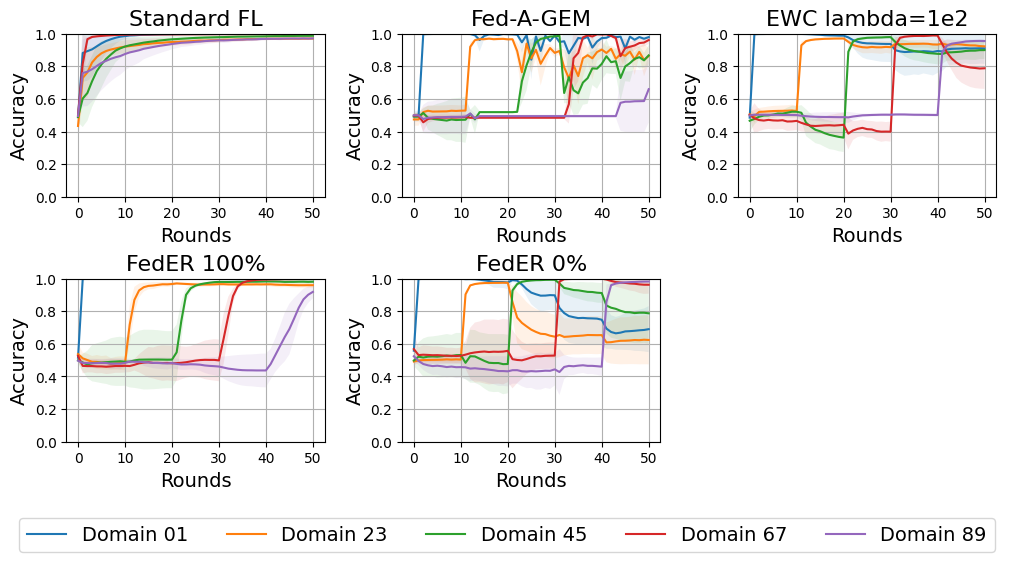

In [86]:

mr0 = MultiReport("./experiment3_task_results/", 0)
mr1 = MultiReport("./experiment3_task_results/", 1)
mr2 = MultiReport("./experiment3_task_results/", 2)
mr3 = MultiReport("./experiment3_task_results/", 3)
mr4 = MultiReport("./experiment3_EWC_results/", 1)


p = Plot(shape=(2, 3))

p.plot_all_metrics((0, 0), "accuracy", mr0, title="Standard FL", add_labels=True)
p.plot_all_metrics((0, 1), "accuracy", mr1, title="Fed-A-GEM")
p.plot_all_metrics((1, 0), "accuracy", mr2, title="FedER 100%")
p.plot_all_metrics((1, 1), "accuracy", mr3, title="FedER 0%")
fig, ax = p.plot_all_metrics((0, 2), "accuracy", mr4, title="EWC lambda=1e2")
ax[1,2].set_visible(False)  # Hide the empty subplot

# fig.suptitle("Client accuracies of every tested FL algorithm (FTIL)", fontsize=fig_title_font_size)
fig.legend(loc='lower center', ncol=5, fontsize=legend_font_size)
fig.subplots_adjust(bottom=0.2)

fig.savefig("exp3_FL_domain_accuracy_task.svg", format="svg", bbox_inches='tight')

Metric Domain _01 not found in report {'ILVariant': 'Task', 'ILStrategy': 'Fed-A-GEM'}
Metric Domain _01 not found in report {'ILVariant': 'Task', 'ILStrategy': 'Fed-A-GEM'}
Metric Domain _01 not found in report {'ILVariant': 'Task', 'ILStrategy': 'Fed-A-GEM'}
Metric Domain _01 not found in report {'ILVariant': 'Task', 'ILStrategy': 'Fed-A-GEM'}
Metric Domain _01 not found in report {'ILVariant': 'Task', 'ILStrategy': 'Fed-A-GEM'}


TypeError: object of type 'numpy.float64' has no len()

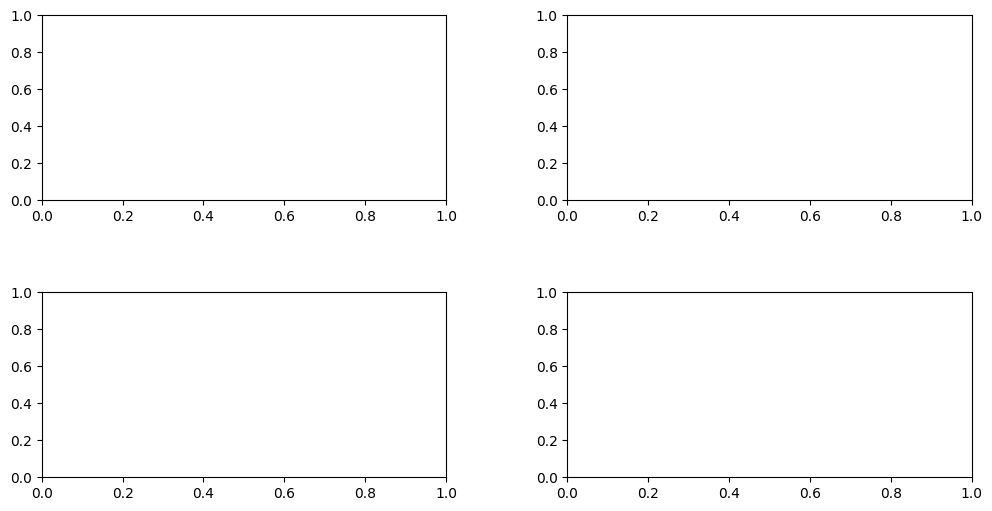

In [87]:
mrtest1 = MultiReport("./experiment3_task_20roundsPT_results/", 0)
mrtest2 = MultiReport("./experiment3_task_20roundsPT_results/", 1)

p = Plot(shape=(2, 2))

p.plot_all_metrics((0, 0), "Domain ", mrtest1, title="Fed-A-GEM 20Rounds/task", add_labels=True)
p.plot_all_metrics((1, 0), "accuracy", mrtest2, title="Fed-ER 20Rounds/task", add_labels=True)
meantest1, stdtest1 = mrtest1.get_mean_var_metric("accuracy_global")
p.plot_mean_std((0,1), meantest1, stdtest1, title="Fed-A-GEM 20Rounds/task", name="Global Accuracy", y_label="Accuracy")
meantest2, stdtest2 = mrtest2.get_mean_var_metric("accuracy_global")
p.plot_mean_std((1,1), meantest2, stdtest2, title="Fed-ER 20Rounds/task", name="Global Accuracy", y_label="Accuracy")
